<a href="https://colab.research.google.com/github/maricmenezes/Machine-Learning-com-Spark/blob/main/Notebook3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### <font color = PaleGreen> Instalação do Spark e Leitura dos dados



In [1]:
# Instalando o PySpark
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=ae3555fe5bbdf59e7dff0cf979445c60b29e5c5d8313be35bbc1f2f9894a762f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [6]:
# Iniciando uma sessão Spark
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

In [7]:
#Leitura dos dados através do ambiente Colab.
#Retirado de: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
dados = spark.read.csv("/content/imdb-reviews-pt-br.csv",
                       escape="\"",
                       header=True,
                       inferSchema=True)

### <font color = PaleGreen> **Análise Exploratória dos dados**



* O **tamanho** dos dados
* Os **campos** e o tipo
* O **conteúdo** em cada campo
* A **proporção** das categorias


In [8]:
# O tamanho dos dados
print(f'N° de Linhas:{dados.count()}', f'N° de colunas:{len(dados.columns)}')

N° de Linhas:24744 N° de colunas:4


In [9]:
# campos e tipos
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [10]:
# Conteudo
dados.limit(99).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

In [12]:
# Apresentação de comentários interpretados como positivos e negativos
print("Negativo")
dados.filter(dados.id == 190).select("text_pt").show(truncate = False)
print("Positivo")
dados.filter(dados.id == 12427).select("text_pt").show(truncate = False)

Negativo
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                 

In [13]:
# Contabilizando os tipos de comentários
dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|12353|
|      neg|12391|
+---------+-----+



### **<font color = PaleGreen> Limpeza e processamento dos dados**

Para realizar a limpeza e o processamento dos dados foram utilizadas duas técnicas pertinentes ao processamento de linguagem natural: tokenização e remoção de stopwords.

A Tokenização consiste em dividir uma frase em palavras ou tokens.
A remoção de stopwords consiste em retirar palavras que não auxiliam na interpretação do texto como preposições, artigos e pronomes.

Além disso, também foram removidos os caracteres especiais pois não contribuem para a interpretação do texto.

###<font color = PaleGreen> **WordCloud**

A partir da visualização de uma nuvem de palavras ou wordcloud, é possível observar as palavras que mais se repetem nas avaliações de filme

A ideia é coletar as palavras usando *list comprehension* e aplicando a função `collect()` em uma [amostra](https://spark.apache.org/docs/latest/api/python/reference/pyspark.sql/api/pyspark.sql.DataFrame.sample.html), já que esta função exige muitos recursos de processamento do spark.


In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [16]:
wordcloud = WordCloud(background_color = 'white',
                      width = 1000,
                      height = 600,
                      collocations = False,
                      prefer_horizontal = 1).generate(str(tudo))

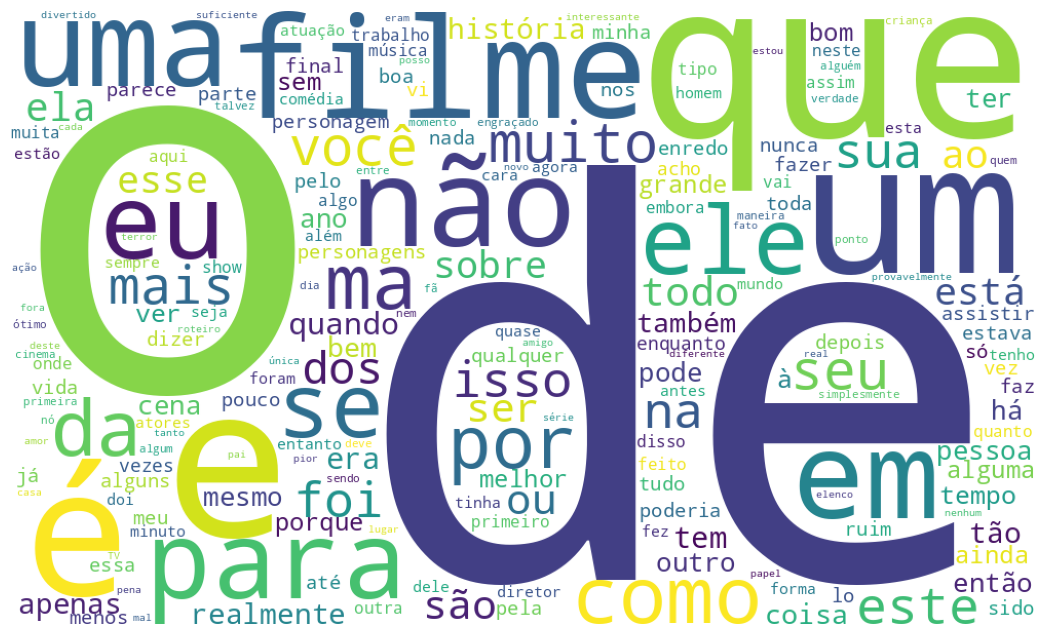

In [17]:
plt.figure(figsize=(20,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

####<font color = PaleGreen> Remoção de caracteres especiais

In [19]:
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [20]:
amostra = spark.createDataFrame([
       ("Oi, JP! Blz?",),
       ("$$$\\ |~ Parabéns ~| \\$$$",),
       ("(#amovc #paz&amor ^.^)",),
       ("\"bora *_* \"",),
       ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
       ("{comprar: arroz; feijão e pepino}  //",),
       ("!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~",),
       ("ana@gmail.com",)
], ["textos"])


In [22]:
import pyspark.sql.functions as f

amostra = amostra.withColumn("texto_regex", f.regexp_replace("textos", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))



In [23]:
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+
|textos                                    |texto_regex                    |
+------------------------------------------+-------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |
|"bora *_* "                               |bora                           |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |
|{comprar: arroz; feijão e pepino}  //     |comprar arroz feijão e pepino  |
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~          |[]                             |
|ana@gmail.com                             |anagmailcom                    |
+------------------------------------------+-------------------------------+



In [24]:
# Remoção de espaços em branco
amostra = amostra.withColumn("texto_limpo", f.trim(amostra.texto_regex))
amostra.show(truncate = False)

+------------------------------------------+-------------------------------+-----------------------------+
|textos                                    |texto_regex                    |texto_limpo                  |
+------------------------------------------+-------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                      |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                     |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                  |amovc pazamor                |
|"bora *_* "                               |bora                           |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad             |vc foi selecionad            |
|{comprar: arroz; feijão e pepino}  //     |comprar arroz feijão e pepino  |comprar arroz feijão e pepino|
|!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~    

In [25]:
#Remoção de caracteres especiais
dados = dados.withColumn("texto_regex", f.regexp_replace("text_en", "[\$#,\"!%&'()*+-./:;<=>?@^_`´{|}~\\\\]", ""))


In [26]:
dados.limit(2).show(truncate=False)

+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
#Remoção dos espaços do começo e do final de cada frase:

dados = dados.withColumn("texto_limpo", f.trim(dados.texto_regex) )

In [28]:
dados.limit(2).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|
+---+--------------------+--------------------+---------+--------------------+--------------------+



####<font color = PaleGreen> **Tokenização**

In [29]:
#Tokenização
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = "texto_limpo", outputCol = "tokens")
tokenizado = tokenizer.transform(dados)

In [30]:
tokenizado.select("texto_limpo", "tokens").show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [32]:
from pyspark.sql.types import IntegerType
# Divisão dos comentários em tokens
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())
tokenizado.select("texto_limpo", "tokens")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

#### <font color = PaleGreen>**StopWords**


In [39]:
#Remoção de Stopwords utilizando biblioteca NLTK do Python
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
stop_A = stopwords.words("portuguese")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
#Remoção de Stopwords utilizando PySpark
from pyspark.ml.feature import StopWordsRemover

stop_B = StopWordsRemover.loadDefaultStopWords("portuguese")

In [43]:
# Remoção de stopwords dos depoimentos sobre os filmes
remover = StopWordsRemover(inputCol = "tokens", outputCol = "texto_final")
feature_data = remover.transform(tokenizado)


In [44]:
feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|B

In [45]:
# Contagem de tokens antes e depois do stopwords.
feature_data.select("tokens", "texto_final")\
          .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
          .withColumn("Freq_tokens_limpos",  countTokens(f.col("texto_final"))).show()


+--------------------+--------------------+-----------+------------------+
|              tokens|         texto_final|Freq_tokens|Freq_tokens_limpos|
+--------------------+--------------------+-----------+------------------+
|[once, again, mr,...|[mr, costner, dra...|        168|                73|
|[this, is, an, ex...|[example, majorit...|        232|               131|
|[first, of, all, ...|[first, hate, mor...|        215|               111|
|[not, even, the, ...|[even, beatles, w...|        308|               169|
|[brass, pictures,...|[brass, pictures,...|        238|               140|
|[a, funny, thing,...|[funny, thing, ha...|        115|                52|
|[this, german, ho...|[german, horror, ...|        156|                74|
|[being, a, longti...|[longtime, fan, j...|        136|                73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|                75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|                99|
|[cage, plays, a, ...|[ca

###<font color = PaleGreen> **Vetorização**


A vetorização dos dados permite transformá-los da linguagem humana e não estruturada para uma maneira mais compreensível ao computador, ou seja, **codificando em números**, sendo possível assim associar cada um dos textos a um sentido e significado delimitados.


O **Bag of Words**, ou sacola de palavras em português, é uma lista que contém todas as palavras que estão nos textos de maneira não repetida e tem papel importante para **identificar as palavras mais recorrentes** e entender se elas agregam algum sentimento.


Aqui no spark o bag of words não é representado por uma matriz do vocabulário como no python, e sim com uma estrutura específica que cria uma **estrutura especifica** que faciliar a compreensão nos modelos.

Alternativas para vetorização: matriz_esparsa, countvectorizer, Hashing TF...



In [46]:
from pyspark.ml.feature import CountVectorizer

cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(df)
df = model.transform(df)


#### **[CountVector](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html)**: Frequência das palavras em cada

Para cada observação é gerado vetor com a seguintes estrutura: \\
 `[número de features, [cód. das palavras na ordem do vocabulário],[frequência de cada palavra]]`

In [48]:
# Countvectorizer

from pyspark.ml.feature import CountVectorizer
cv = CountVectorizer(inputCol="texto_final", outputCol="CountVec")
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final','CountVec').limit(5).show()#truncate=False

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(135899,[0,7,8,11...|
|[example, majorit...|(135899,[1,2,3,8,...|
|[first, hate, mor...|(135899,[0,2,4,11...|
|[even, beatles, w...|(135899,[0,1,2,4,...|
|[brass, pictures,...|(135899,[1,3,5,8,...|
+--------------------+--------------------+



#### **[Hashing TF](https://spark.apache.org/docs/3.2.1/api/python/reference/api/pyspark.ml.feature.HashingTF.html)**: alternativa para o Countvector

É gerado a mesma estrutura, entretando aqui limitamos o número de palavras contabilizadas.

In [49]:
# Hashing TF
# Hashing TF é uma opção alternativa para o countvector que limita a quantidade de palavras, no caso, 50 palavras diferentes serão contadas. #numFeatures=1000
from pyspark.ml.feature import HashingTF

hashingTF = HashingTF(inputCol="texto_final", outputCol="hashingTF")
hashingTF.setNumFeatures(50)

HTFfeaturizedData = hashingTF.transform(countVectorizer_features)




In [50]:
HTFfeaturizedData.select("texto_final", "hashingTF").limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(50,[0,5,6,7,8,10...|
|[example, majorit...|(50,[0,1,2,3,4,5,...|
|[first, hate, mor...|(50,[0,1,2,3,5,6,...|
|[even, beatles, w...|(50,[0,1,2,3,4,5,...|
|[brass, pictures,...|(50,[0,1,2,3,4,5,...|
+--------------------+--------------------+



####<font color = PaleGreen> **TF-IDF**: estabelecendo pesos

O TF-IDF não apenas contabiliza as diferentes palavras, mas também gera pesos para cada um a partir da predomância nos dados.

In [51]:
#TF-IDF
from pyspark.ml.feature import IDF
idf = IDF(inputCol="hashingTF", outputCol="features")
idfModel = idf.fit(HTFfeaturizedData)
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData)


In [52]:
TFIDFfeaturizedData.select('texto_final', 'features').limit(5).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

####<font color = PaleGreen> **Codificando**: variável resposta.
Lembrando que ensinaremos que todas essas palavras estarão associadas ao sentimento do depoimento, positivo ou negativo, entretando precisamos codificar `neg` e `pos` para 0 e 1 e podemos usar o `StringIndexer`



In [70]:
# Conversão de texto para número

TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|12353|
|      neg|12391|
+---------+-----+



In [54]:
# Codificando a variável resposta.
# 1. replace
# 2. stringindexer (sentiment -> label)

from pyspark.ml.feature import StringIndexer

stringindexer = StringIndexer(inputCol="sentiment", outputCol="label")
dados = stringindexer.fit(dados).transform(dados)



In [55]:
# Quem é 0 e quem é 1?
dados.groupBy(['sentiment','label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|12353|
|      neg|  0.0|12391|
+---------+-----+-----+



####<font color = PaleGreen> **Pipeline**: Transformação dos dados



In [56]:
# Unindo nossas transformações.
from pyspark.ml import Pipeline


tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")


pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf])

In [57]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [58]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

###<font color = PaleGreen> **Modelo**
Para que seja possível identificar cometários positivos ou negativos entre os depoimentos, é necessário criar um modelo através do qual o computador consiga classificar os depoimentos. Após a identificação dos comentários positivos e negativos feita utilizando o PLN, passaremos ao modelo de classificação.

Para testar nossos dados usaremos todos os procedimentos realizados em Limpeza e processamento dos dados e a vetorização que estabelece pesos para as palavras construidas a partir do TF-IDF.





In [59]:
# Entendendo nossos dados
featureDF = dados_transformados.select(['features', 'label'])


In [60]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [61]:
# tipo lido pelo modelo.
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [62]:
#Pipeline de transformação e ajuste
from pyspark.ml import Pipeline
from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol="texto_limpo", outputCol="tokens")
stopwords = StopWordsRemover(inputCol="tokens", outputCol="texto_final")
hashingTF = HashingTF(inputCol=stopwords.getOutputCol(), outputCol="HTF", numFeatures=1000)
tfidf = IDF(inputCol="HTF", outputCol="features")
dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10)

pipeline = Pipeline(stages = [tokenizer,stopwords, hashingTF, tfidf, dt])

####<font color = PaleGreen> **Amostra e Treino**

In [63]:
# separando os dados em conjuntos de treino e teste
train, test = dados.randomSplit([0.7, 0.3], seed = 101)

In [64]:
# ajustando o modelo com a pipeline
dt_model = pipeline.fit(train)

In [65]:
# aplicando na base teste
predictions = dt_model.transform(test)

In [66]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Brass pictures mo...|  0.0|[brass, pictures,...|[brass, pictures,...|(1000,[3,6,7,11,3...|(1000,[3,6,7,11,3...|  [229.0,634.0]|[0.26535341830822...|       1.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

####<font color = PaleGreen> **Teste e Métricas**


In [67]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName='accuracy')
accuracy = evaluator.evaluate(predictions)
print("Acuracia = %s" % (accuracy))

Acuracia = 0.6600532623169107


In [69]:
nova_base = spark.createDataframe([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "texto_limpo"])

AttributeError: ignored

#### **Nova frase**